# NMR Echo Train processing and creation of an NMR log in Real-Time:

This Jupyter Notebook uses the existing MRIL T2 bin porosities to create an NMR log echo train with introduced noise that we will then be used for the T2 inversion. 

This T2 inversion method was developed in collaboration with chatGPT which has become quite popular lately, so I decided to experiment with using this AI tool to perform this NMR log T2 inversion using the SciPy optimization library in Python with Tikhonov regularization, which incorporates a penalty term based on the sum of the squared parameters. Although the initial code provided by ChatGPT required some fine-tuning, it was a great starting point.

The repository on GitHub also includes a complete Geolog project with Geolog python loglans to complete the same process.

The process starts with the existing bin porosities for a MRIL C tool well where we create an echo train with the multi-exponential decay rate shown in the function below:

    def func(x,p1,p2,p3,p4,p5,p6,p7,p8):
    return (p1*np.exp(-x/4)+p2*np.exp(-x/8)+p3*np.exp(-x/16)+p4*np.exp(-x/32)+p5*np.exp(-x/64)+p6*np.exp(-x/128)+p7*np.exp(-x/256)+p8*np.exp(-x/512))

In essence we could just add noise to this 

    y_noise  = noise * np.random.normal(size=xdata.size)
    ydata = y + y_noise

where xdata is the time in msec for 200 echoes with a TE of 1.2 msec:

    # create x array with 200 elements
    num_echoes = 200
    TE = 1.2  # echo spacing (ms)
    x = np.arange(num_echoes) * TE
    xdata = x

and ydata is the echo train amplitudes. We stack the echo_train_real for better signal to noise and then perform the inversion using the same SciPy T2 inversion techniques as before. 

After that all we would really need to do is apply some form of T2 inversion of the new synthetic echo train with noise using some methods from SciPy. 

    '''
    -----------------------------------------------------------------------------------------------
      T2 Inversion using SciPy with regularization or SciPy curve_fit options:
    -----------------------------------------------------------------------------------------------
    '''
 
    if method == 'least_squares' : 
        # Set the value of alpha
        alpha = 0.1
        # Set the initial parameter values
        p0 = np.ones(8)
        # Set the bounds
        bounds = ([0]*8, [20]*8)
        # Fit the data to the function with L2 regularization using scipy.optimize
        result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=bounds)
        popt = result.x    
    elif method == 'Optimize':
        lambda_ = 0.1  #started with 0.1
        p0 = np.ones(8)
        result = minimize(obj_func, p0, args=(xdata, ystack, lambda_), method='L-BFGS-B', bounds=[(0, 20)]*8)
        popt = result.x
    elif method == 'Curve_fit_simple' : 
        popt, pcov = curve_fit(func, xdata, ystack, method='trf', bounds=(0.05, [20, 20, 20, 20, 20, 20, 20, 20])) 
        
![NMR_log](NMR_log.gif)


We also have all of this code as Geolog python loglans with a complete Geolog project included in this repository.

![Geolog_Image](Geolog_loglan.png)

There is also a Geolog layout to view the new T2 inversion results along with the original NMR log data to compare your results to.

![Geolog_Image](results.png)

Please let us know if there are any issues.

## Import Python libraries:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 12:33:54 2020

@author: craig
"""
%matplotlib inline
#%matplotlib tk

#from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Read in NMR log and T2 bin data used to create the echo train in this instance:

In [2]:
#df = pd.read_csv('nmr.csv',index_col=0)
df = pd.read_csv('nmr.csv')

print(df.head())

    Depth   MPHI      P1      P2      P3      P4      P5     P6      P7  \
0  7177.0  3.294  0.7960  0.6230  0.1180  0.0130  0.0160  0.172  0.5560   
1  7177.5  3.002  0.3010  0.3500  0.2220  0.1540  0.2040  0.392  0.6140   
2  7178.0  3.289  0.0620  0.2170  0.3430  0.3800  0.4260  0.528  0.6300   
3  7178.5  4.568  0.0480  0.3030  0.6280  0.7910  0.7770  0.715  0.6670   
4  7179.0  5.397  0.1835  0.3435  0.6465  0.9735  1.0485  0.902  0.7175   

       P8   MFFI    MBVI  
0  0.9980  1.756  1.5370  
1  0.7650  2.129  0.8730  
2  0.7020  2.668  0.6220  
3  0.6390  3.590  0.9790  
4  0.5825  4.224  1.1735  


## Define the level spacing, number of levels to stack and random noise to introduce into the echo trains:

In [7]:
'''
    ---------------------------------------------------------------------------
    This is where we want to stack the data for a less noisy echotrain
    
    Set Level Spacing, Stacking levels and Noise below
      
            *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
    ---------------------------------------------------------------------------
'''
level_spacing = .5  # well level spacing and this model works best on 0.5 data???
stack_levels  = 3   # odd numbers are geat, even changes level spacing in new depth offset of 0.25 ' 
noise         = 1.5 # in porosity units
'''
--------------------------------------------------------------------------------
             *** Stack_levels from 1 (no stacking) to 9 stacked levels *** 
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

                         *** Set T2 Inversion parameters ***

--------------------------------------------------------------------------------

Do you want to use SciPy Optimization or SciPy least_squares methods, both with regularization?

SciPy curve_fit does not have regularization so far.
'''
method = []

method = 'least_squares'
#method = 'Optimize'
#method = 'Curve_fit_simple'

'''
Set the value of alpha for least_squares regularization, or lambda_ for optimization regularization
'''
alpha   = 0.05  # least squares regularization
lambda_ = 0.05  # Optimization regularization


# Create Echo Trains and then use SciPy Optimization with Regularization for the T2 inversion:

## For SciPy least_squares Alpha=0 has no optimization

## The parameter **lambda_** in SciPy Optimization determines the strength of the regularization. 
### Supposedly, a smaller value of lambda_ will result in a stronger regularization and a simpler solution, 
this might not be true and a smaller lambda_ has less reqularization???

#### You can adjust the value of lambda_ to find a good balance between fitting the data and preventing overfitting.

##### Allow for you to choose between SciPy Optimization or SciPy Curve_fit methods. 


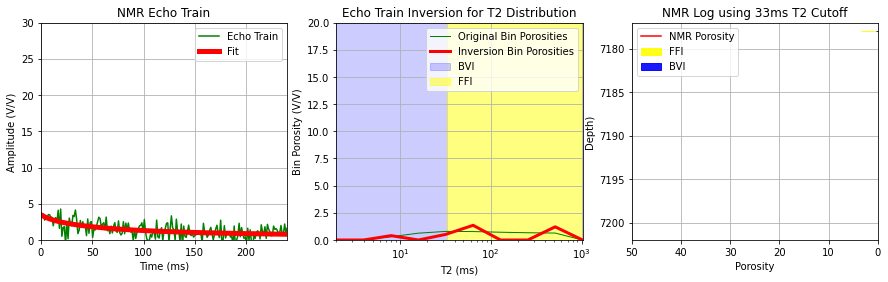

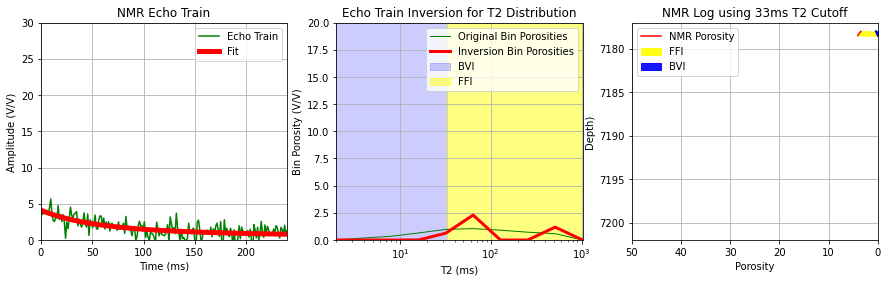

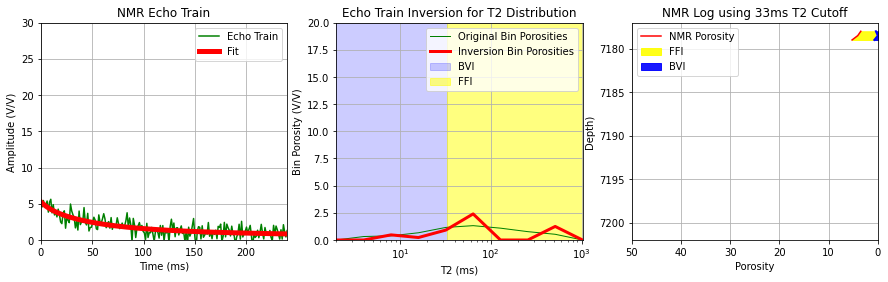

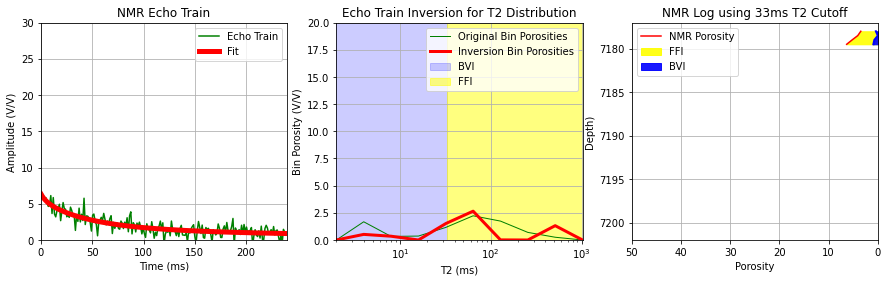

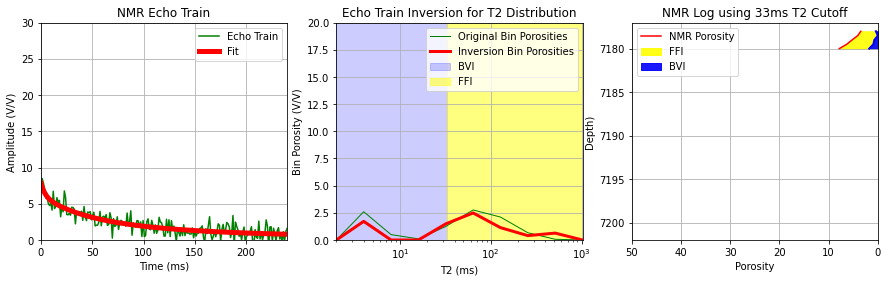

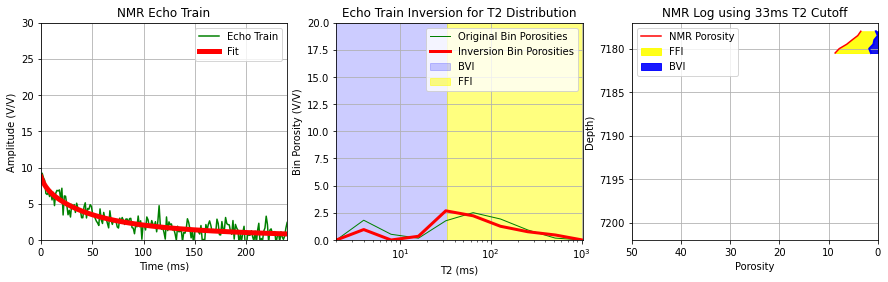

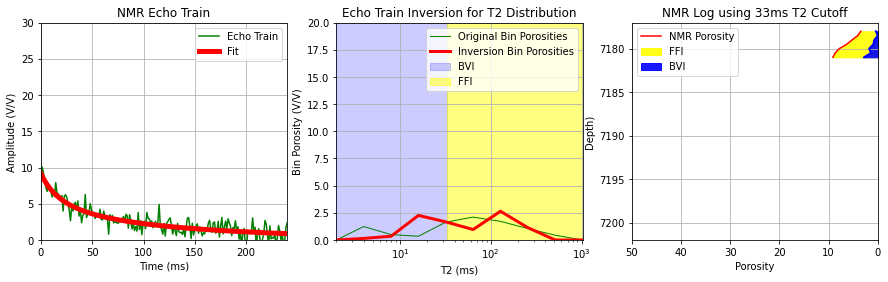

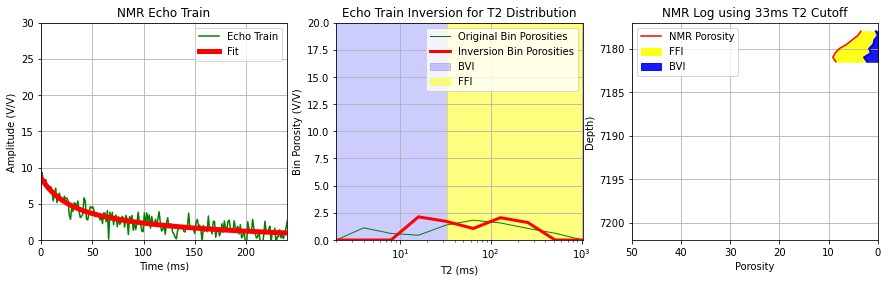

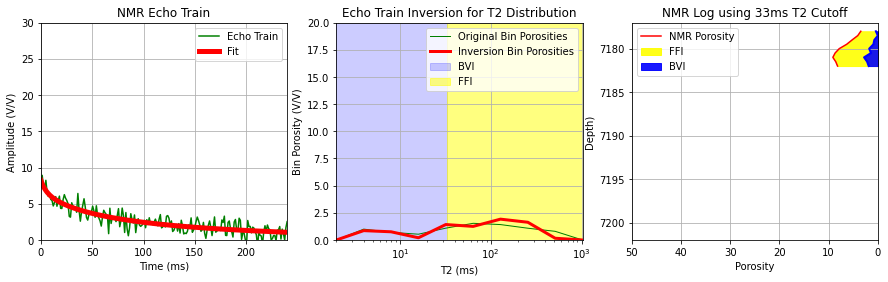

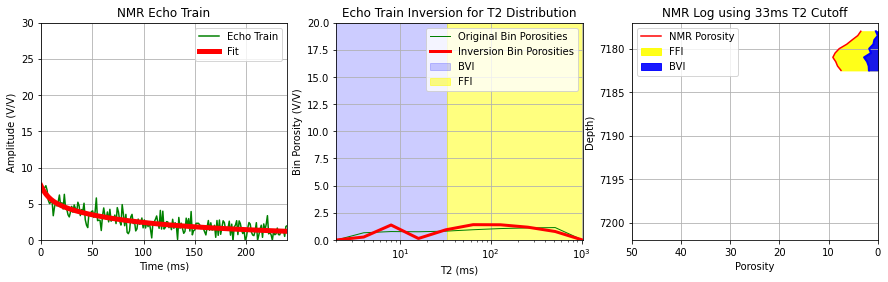

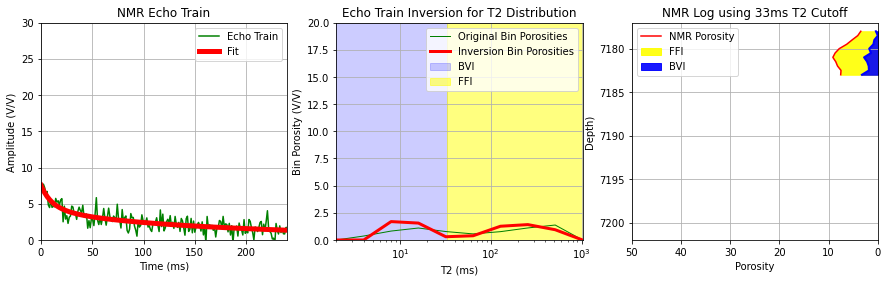

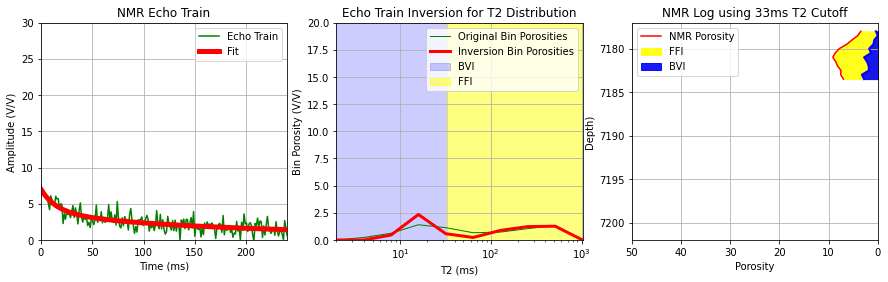

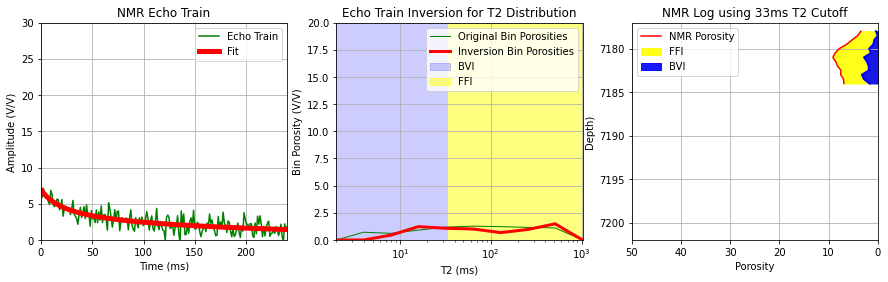

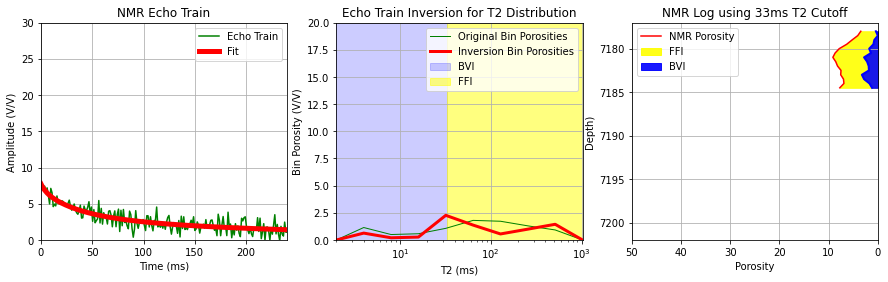

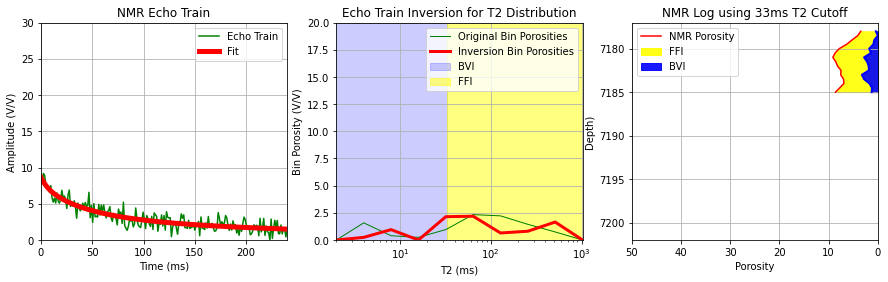

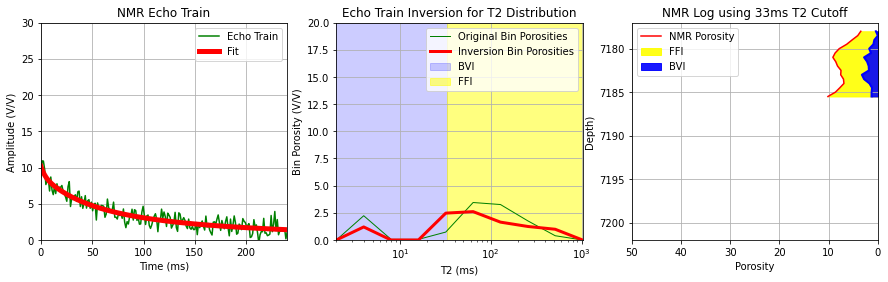

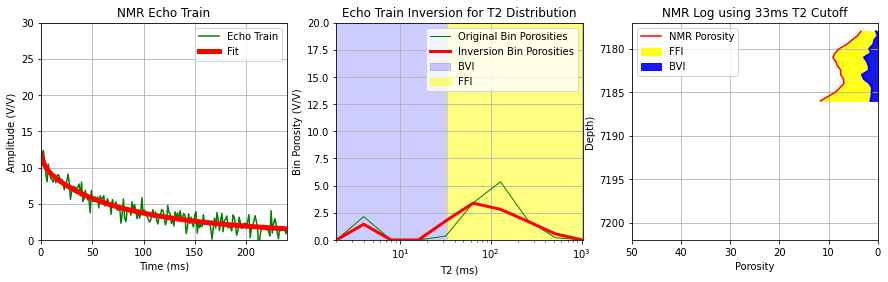

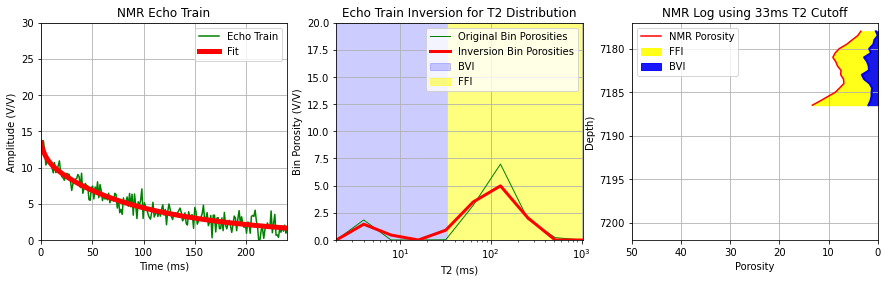

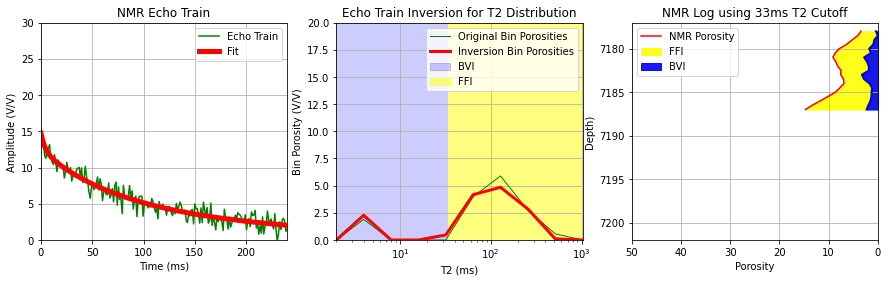

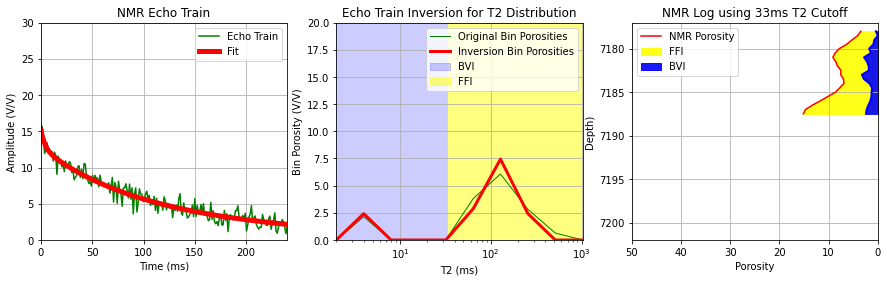

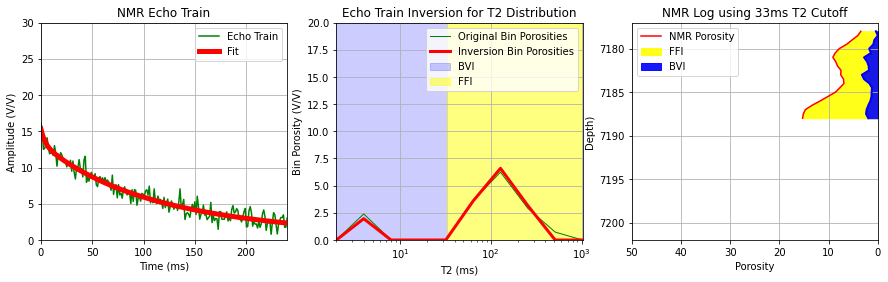

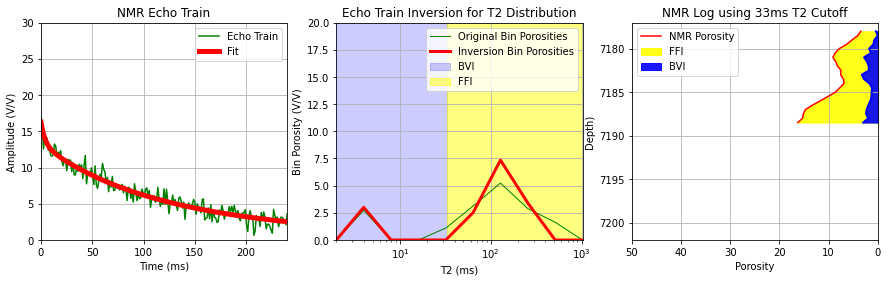

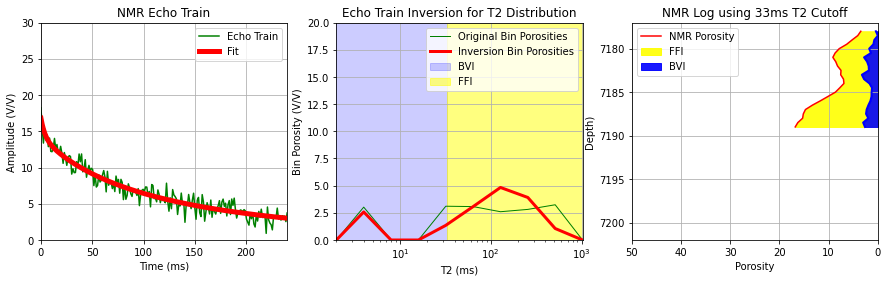

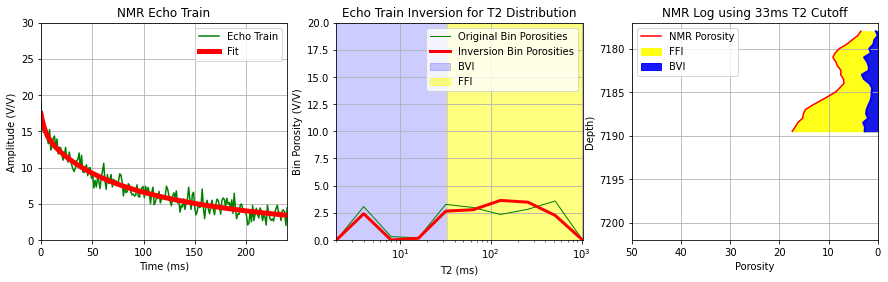

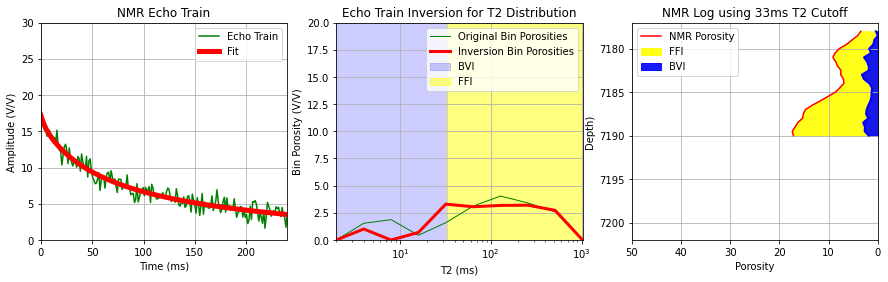

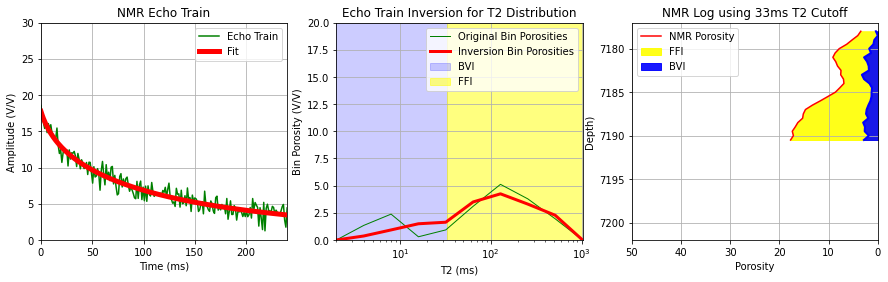

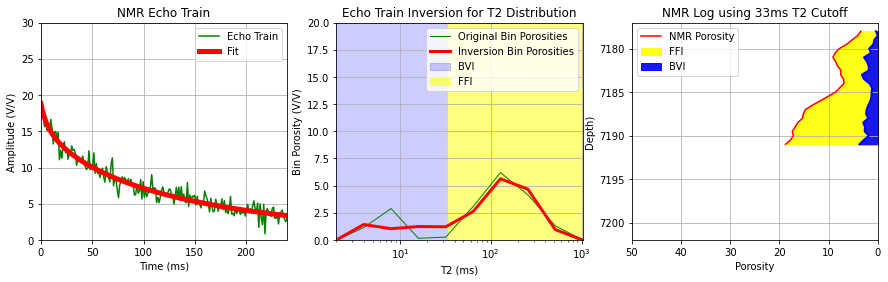

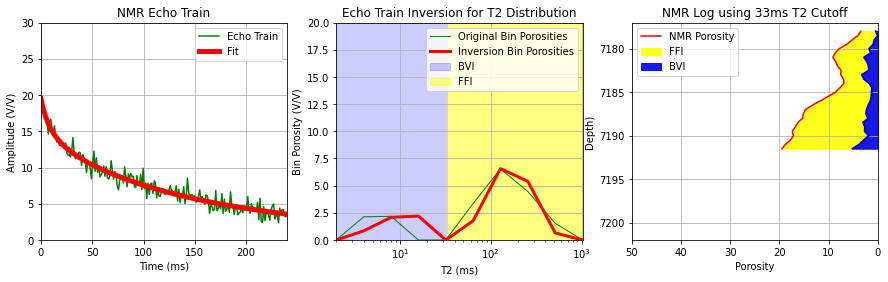

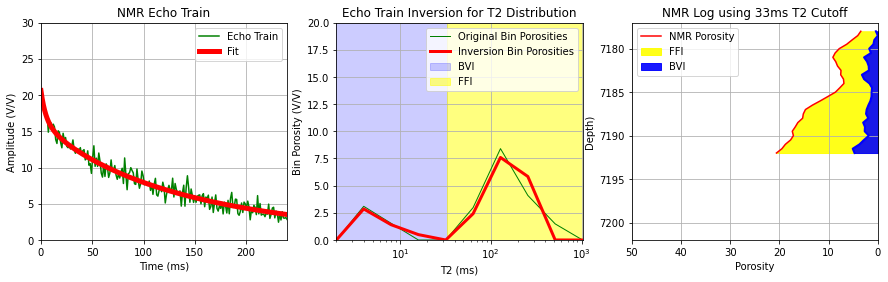

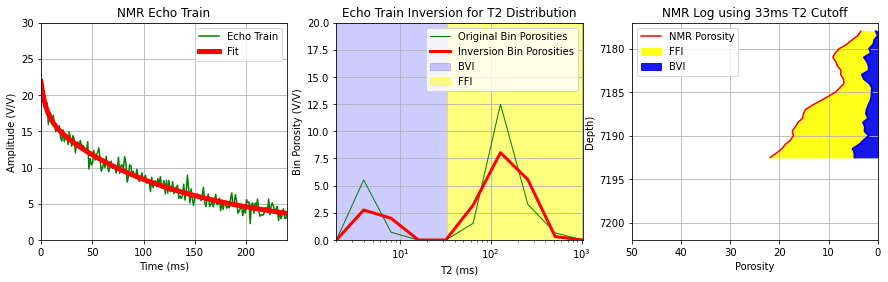

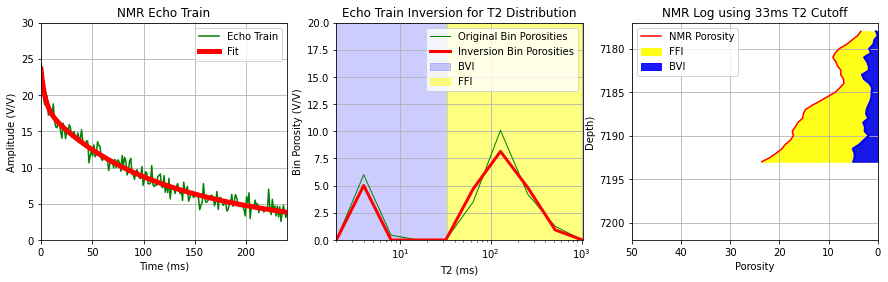

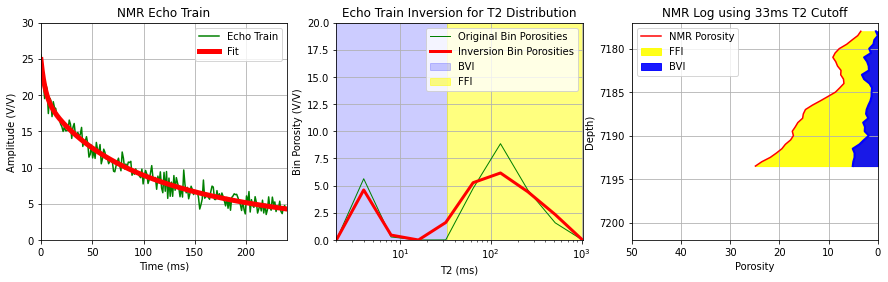

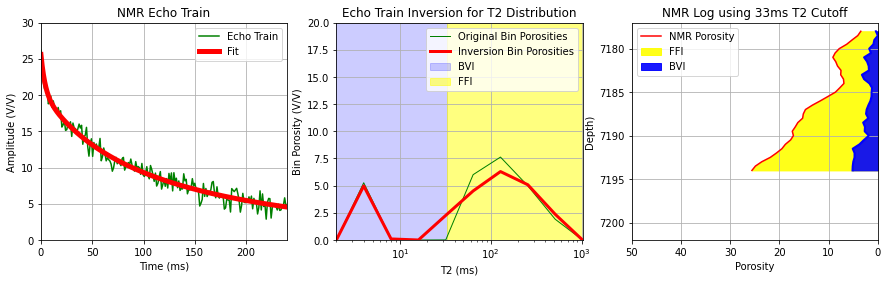

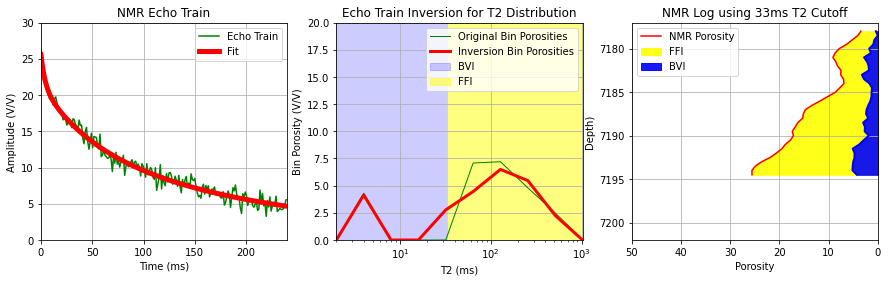

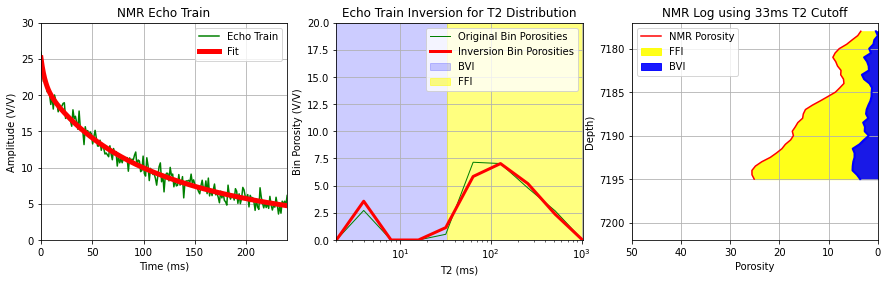

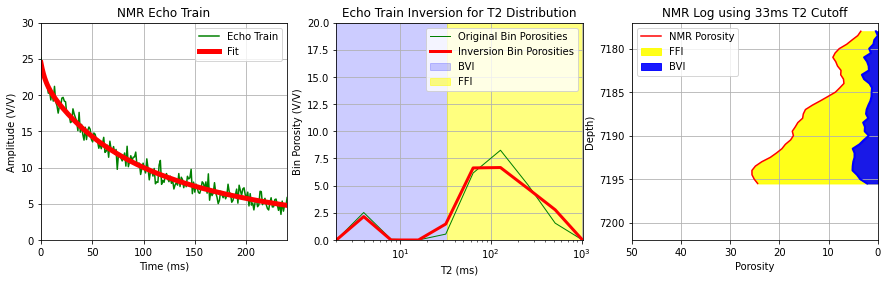

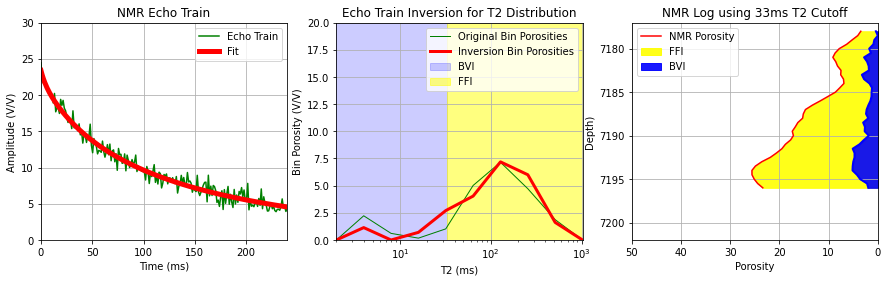

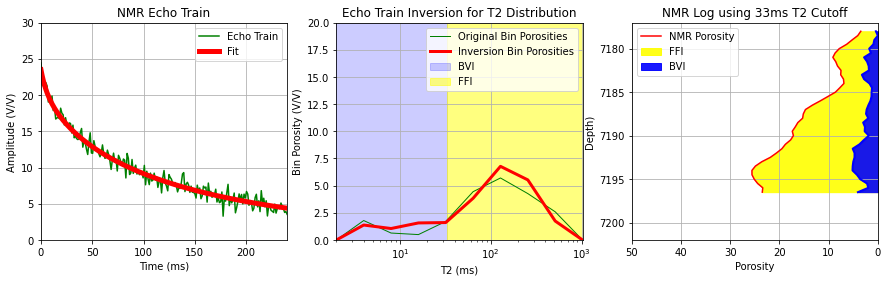

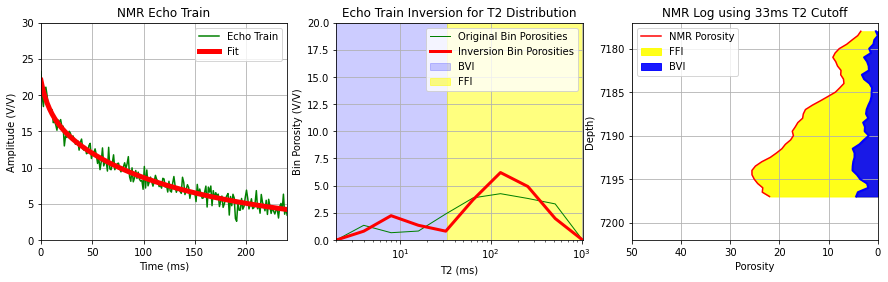

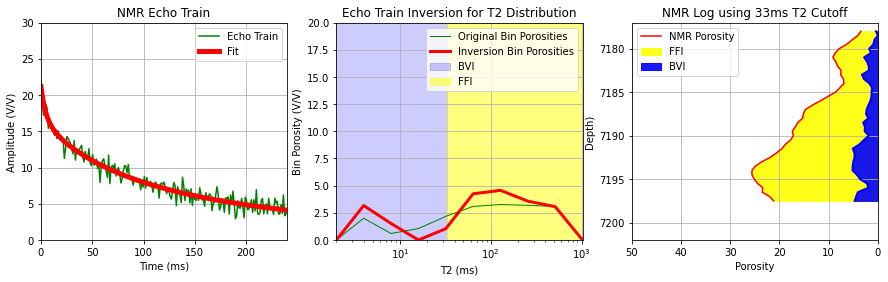

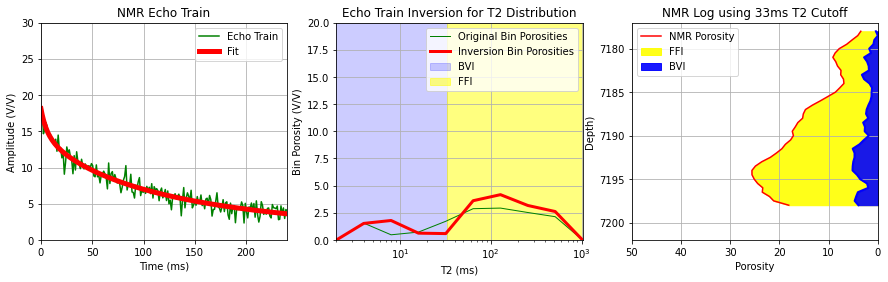

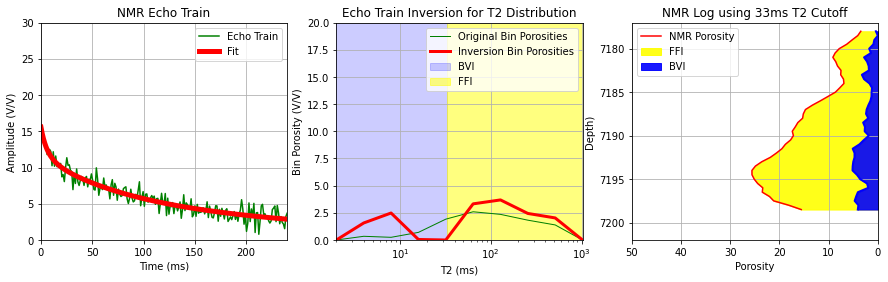

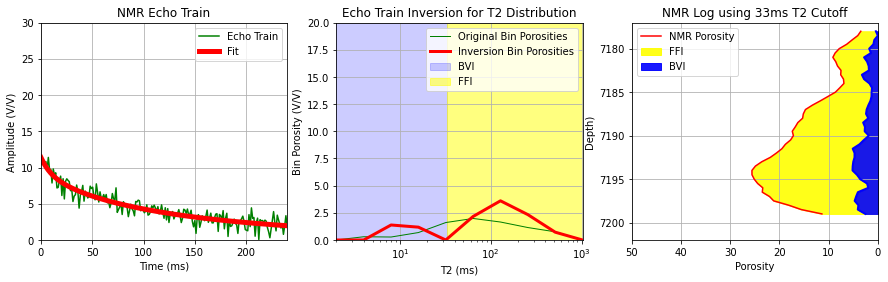

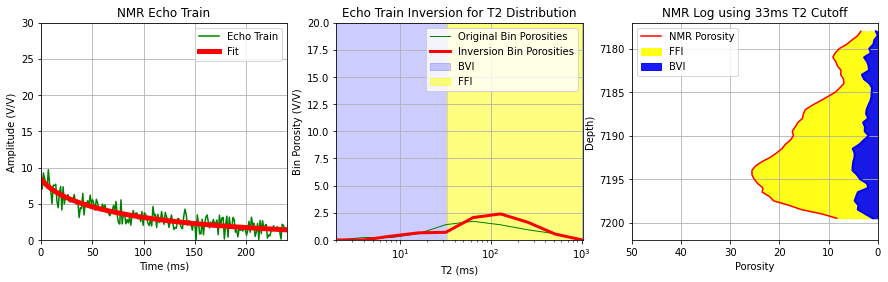

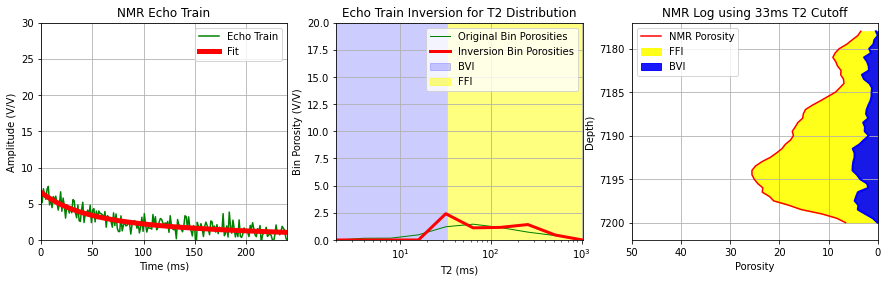

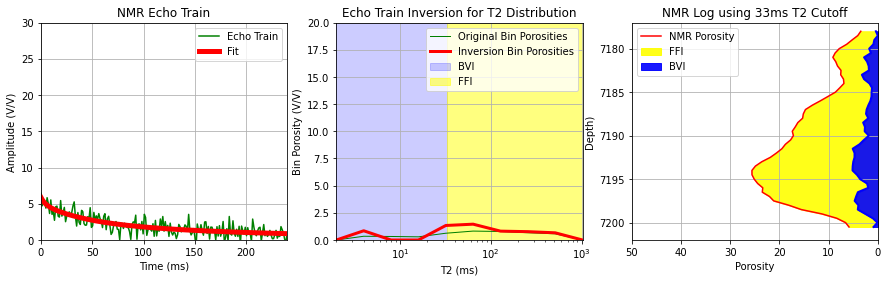

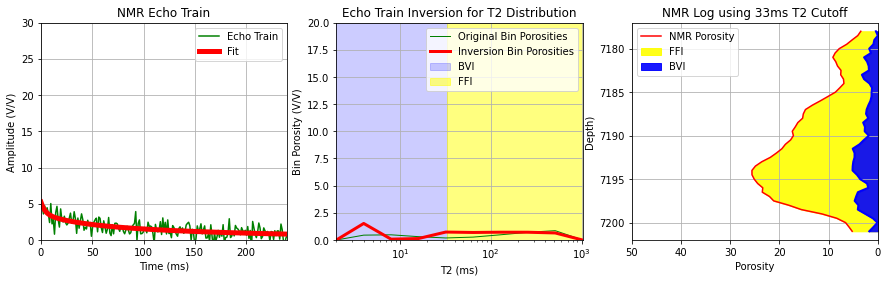

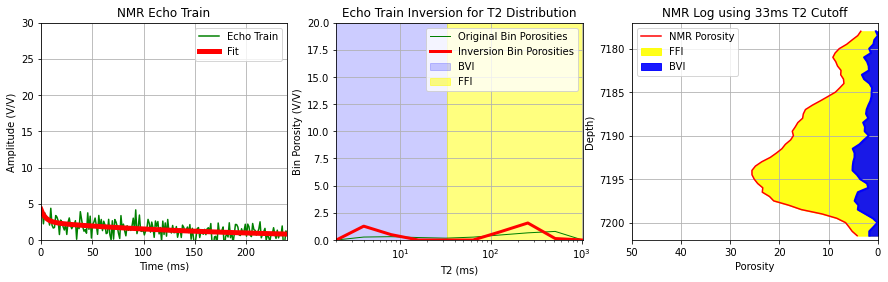

In [8]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

T2 =[2,4,8,16,32,64,128,256,512,1024,2048]

def func(x,p1,p2,p3,p4,p5,p6,p7,p8):
    return (p1*np.exp(-x/4)+p2*np.exp(-x/8)+p3*np.exp(-x/16)+p4*np.exp(-x/32)+p5*np.exp(-x/64)+p6*np.exp(-x/128)+p7*np.exp(-x/256)+p8*np.exp(-x/512))


def obj_func(params, x, y, lambda_):
    p1, p2, p3, p4, p5, p6, p7, p8 = params
    residuals = y - func(x, p1, p2, p3, p4, p5, p6, p7, p8)
    regularization = lambda_ * (p1**2 + p2**2 + p3**2 + p4**2 + p5**2 + p6**2 + p7**2 + p8**2)
    return np.sum(residuals**2) + regularization

# Define the objective function to be minimized, including a regularization term
def objective(p, x, y, alpha):
    y_pred = func(x, *p)
    error = y - y_pred
    regularization_term = alpha * np.sum(np.square(p))
    return np.concatenate([error, np.sqrt(alpha) * p])


deptharray=[]
mphiarray=[]    
mbviarray=[]
mffiarray=[]    
echo=[]
ystack=[]
T21=[]
T22 = []
#ystack2=[]
#ystackecho=[]

for index, row in df.iterrows():
    P0=0
    P1=row['P1']
    P2=row['P2']
    P3=row['P3']
    P4=row['P4']
    P5=row['P5']
    P6=row['P6']
    P7=row['P7']
    P8=row['P8']
    P9=0
    P10=0
    mphi=row['MPHI']
    mbvi=row['MBVI']
    depth=row['Depth']
    bins=[P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10]

    #Define the data to be fit with some noise:
    '''
      This is the xdata for TE (1.2msec) x number of echoes for 240ms of echo train data
    '''
    xdata = np.linspace(0, 240, 201)

    '''
      Calculate Echo Train data using xdata and func for echo train equation
    '''
    y = func(xdata,P1, P2, P3,  P4, P5, P6,  P7,  P8)

    '''
      add noise to the echo train data to create a typical echo train
    '''
    y_noise  = noise * np.random.normal(size=xdata.size)
    ydata = y + y_noise
    
    '''
      Store Echo Trains in np array
    '''
    echo.append(ydata)
    yecho = pd.DataFrame(echo)
                 
    ''' This is stacking of echo trains for better S/N'''
    if index > stack_levels -1:
        if stack_levels == 1:           
            ystack=ydata
        else:
            for k in range(1,stack_levels): 
    
                if stack_levels == 2:
                    ystack = (echo[index-1]+echo[index])/stack_levels                 
                elif stack_levels == 3:
                    ystack = (echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels ==4:
                    ystack = (echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 5:
                    ystack = (echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels
                elif stack_levels == 6:
                    ystack = (echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 7:
                    ystack = (echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 8:
                    ystack = (echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                elif stack_levels == 9:
                    ystack = (echo[index-8]+echo[index-7]+echo[index-6]+echo[index-5]+echo[index-4]+echo[index-3]+echo[index-2]+echo[index-1]+echo[index])/stack_levels    
                    
                else:
                    print('Stack Levels out of bounds')
     
        '''
        -----------------------------------------------------------------------------------------------
          Optimization using SciPy with regularization or SciPy curve_fit options:
        -----------------------------------------------------------------------------------------------
        '''
        # Fit the function to the data with regularization
        #bnds = [(0, 20)]*8
        
        if method == 'least_squares' : 
            # Set the value of alpha
            #alpha = 0.1
            # Set the initial parameter values
            p0 = np.ones(8)
            # Set the bounds
            bounds = ([0]*8, [20]*8)
            # Fit the data to the function with L2 regularization using scipy.optimize
            result = least_squares(objective, p0, args=(xdata, ystack, alpha), bounds=bounds)
            popt = result.x    
        elif method == 'Optimize':
            #lambda_ = 0.1  #started with 0.1
            p0 = np.ones(8)
            result = minimize(obj_func, p0, args=(xdata, ystack, lambda_), method='L-BFGS-B', bounds=[(0, 20)]*8)
            popt = result.x
        elif method == 'Curve_fit_simple' : 
            #lambda_ = alpha
            #p0 = np.ones(8)
            #popt, pcov = curve_fit(obj_func, p0, y_data, args=(xdata, lambda_))
            popt, pcov = curve_fit(func, xdata, ystack, method='trf', bounds=(0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
            #popt, pcov = curve_fit(obj_func, p0, xdata, ystack, lambda_ ,bounds= (0.05, [20, 20, 20, 20, 20, 20, 20, 20]))        
        
        #print("Inversion Porosities:" , popt)
        
        
        ''' Calculate BVI, MFFI and MPHI '''
        mbviarray.append(popt[0]+popt[1]+popt[2]+0.044*popt[3])    
        mphiarray.append(popt[0]+popt[1]+popt[2]+popt[3]+popt[4]+popt[5]+popt[6]+popt[7])
        mffiarray.append((1-0.044)*popt[3]+popt[4]+popt[5]+popt[6]+popt[7])

        multiplier = (1 - level_spacing)/2
        deptharray.append(depth - (stack_levels-1)/2 + multiplier*(stack_levels-1))
        
        optbins  = [P0,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],P9,  P10] 
        T2       = [2,  4,      8,     16,     32,     64,     128,    256,   512,   1024, 2048]
        #bins    = [P0, P1,    P2,     P3,     P4,     P5,      P6,     P7,    P8,    P9,   P10]


        
        
        
        
        
        
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        #------     Plot Echo Train and create NMR log T2 Dist, MPHI and MBVI from T2 Inversion      -----
        #-------------------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------
        for p in range(1):
            p=0
            
            fig, ax = plt.subplots(1,3,figsize=(15,4))      
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            ax[0].plot(updated_x,updated_y    ,c='green',label='Echo Train')
            ax[0].plot(updated_x,updated_yfit ,c='red',linewidth=5, label='Fit') 
            ax[0].set_xlim(0,240)
            ax[0].set_ylim(0,30)
            ax[0].set_ylabel('Amplitude (V/V)')
            ax[0].set_xlabel('Time (ms)')
            ax[0].set_title('NMR Echo Train')
            ax[0].legend(loc='upper right')
            ax[0].grid()
            
            #ax.figure(2)
            ax[1].semilogx(T2,bins, c='green', linewidth=1, label = 'Original Bin Porosities')
            ax[1].semilogx(T2,optbins,c='red', linewidth=3, label = 'Inversion Bin Porosities')        
            #ax[1].semilogx(33,0.0 ,'b*')
            ax[1].set_xlim(2,1024)
            ax[1].set_ylim(0,20)
            ax[1].set_ylabel('Bin Porosity (V/V)')
            ax[1].set_xlabel('T2 (ms)')
            ax[1].set_title('Echo Train Inversion for T2 Distribution')
            ax[1].axvspan(2,33,alpha=0.2,color='blue',label='BVI')
            ax[1].axvspan(33,1024,alpha=0.5,color='yellow',label='FFI')
            ax[1].legend()
            ax[1].grid()
            
            ax[2].plot(mphiarray,deptharray ,c='red',label='NMR Porosity')
            ax[2].plot(mbviarray,deptharray ,c='blue',linewidth=2)
            ax[2].set_xlim(50,0)
            ax[2].set_ylim(max(df['Depth']),min(df['Depth']))
            #ax[2].set_ylim(12.5,0)
            ax[2].set_ylabel('Depth)')
            ax[2].set_xlabel('Porosity')
            ax[2].set_title('NMR Log using 33ms T2 Cutoff')
            
            ax[2].fill_betweenx(deptharray, mphiarray, 0,  color='yellow', alpha=0.9, label='FFI')   
            ax[2].fill_betweenx(deptharray, mbviarray, 0,  color='blue'  , alpha=0.9, label='BVI')    
            ax[2].legend(loc='upper left')
            ax[2].grid()
              
            plt.draw()  
            updated_x = xdata
            updated_y = ystack
            updated_yfit = func(xdata, *popt)
            plt.pause(0.05)
            #fig.clear()
            plt.close(fig)
            #fig.clf()
                 
            


## SciPy Least_squares
For the above least squares technique above L2 regularization (also known as Ridge regression) is a technique used to prevent overfitting in regression models by adding a penalty term to the objective function that forces the model to have smaller parameter values. The penalty term is proportional to the square of the parameter values, and the strength of the penalty is controlled by the regularization parameter alpha. When alpha is set to 0, there is no regularization and the optimization reduces to a simple least-squares regression. As alpha increases, the penalty for large parameter values increases, and the resulting model tends to have smaller parameter values.

In the example code, the objective function that is minimized by least_squares includes a regularization term that depends on the parameter values p and the regularization parameter alpha. The objective function returns the concatenation of the error between the predicted values and the actual values, and the regularization term multiplied by the square root of alpha. The square root of alpha is included in the regularization term to make it scale linearly with alpha, rather than quadratically.

By setting alpha to a non-zero value, we are able to constrain the optimization to find parameter values that not only fit the data well but also have small magnitudes, thus preventing overfitting. The value of alpha is chosen based on the trade-off between overfitting and underfitting, which is typically done by cross-validation or some other tuning method.

### When alpha = 0, there is no regularization and the optimization reduces to a simple least-squares regression. 

### As alpha increases, the penalty for large parameter values increases, and the resulting model tends to have smaller parameter values.


## SciPy Optimization
The parameter lambda_ for SciPy optimization determines the strength of the regularization. Supposedly, a smaller value of lambda_ will result in a stronger regularization and a simpler solution, while a larger value of lambda_ will result in a weaker regularization and a more complex solution. You can adjust the value of lambda_ to find a good balance between fitting the data and preventing overfitting. 

## However, I think a small lambda_ has less regularization than a large lambda_????


# Write out new NMR T2 inversion results with Echo Train to Excel file:

In [5]:
file_out = pd.merge(df, yecho ,left_index=True,right_index=True)

file_out.to_excel('nmr_echos.xlsx', index = False)